# APTOS 2019 Blindness Detection

# Abstract
Millions of people suffer from diabetic retinopathy,which is the leading cause of blindness among working aged adults.Currently, Medical technicians travel to rural areas to capture images and then rely on highly trained doctors to review the images and provide diagnosis. Our Aim is to solve this problem by using Machine Learning Techniques to Provide Asia Pacific Tele-Ophthalmology Society (APTOS) with an Algorithim that can classify the Image to one of the following Categories:
- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR


![Classification](http://cceyemd.com/wp-content/uploads/2017/08/5_stages.png)

Image source: http://cceyemd.com/diabetes-and-eye-exams/



The First Section of this Notebook will do an Exploratory data analysis(EDA) of the APTOS dataset. 
The second Section of this Notebook will use Different Deep Learning Techniques to Classify The data.


### Linux Commands For working with Kaggle Api on Google Cloud
- !pip install kaggle
- !mkdir -p .kaggle
- !cp kaggle.json .kaggle/
- !ls .kaggle
- !chmod 600 .kaggle/kaggle.json  # set permission
- !~/.local/bin/kaggle competitions download -c aptos2019-blindness-detection

### Tech Versions
- Python 3.5.3
- Tensorflow 2.0

In [22]:
#installing dependencies
import zipfile
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import csv
import random
from keras.utils.np_utils import to_categorical

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# defining global variable path
image_path = 'data/resized train 19'
test_image_path = 'data/resized test 19'
#Load Images as Paths so They Can Be accessed on the Go.
def loadImages(path):
    image_files = sorted([os.path.join(path, file) for file in os.listdir(path) if file.endswith('.jpg')])
    return image_files
image_path_array = loadImages(image_path)
test_data_image_path_array = loadImages(test_image_path)
image_path_array[:5]

['data/resized train 19/000c1434d8d7.jpg',
 'data/resized train 19/001639a390f0.jpg',
 'data/resized train 19/0024cdab0c1e.jpg',
 'data/resized train 19/002c21358ce6.jpg',
 'data/resized train 19/005b95c28852.jpg']

In [3]:
# def morph_func(img):
# 	#uint8 is an unsigned integer from 0 to 255
# 	img=img.astype(np.uint8)
	
# 	#axis=2 for 3d image
# 	findblack=np.sum(img,axis=2)
# 	print(np.min(findblack))
# 	findblack=findblack-np.min(findblack)
# 	findblack[findblack>np.mean(findblack)]=np.mean(findblack)
# 	findblack=findblack/np.max(findblack)
# 	borders=2+np.sum(findblack[:,:int(img.shape[1]/2)]<0.33,axis=1)
	
# 	for i in range(img.shape[0]):
# 		k=borders[i]
# 		img[i]=img[i,np.linspace(k,img.shape[1]-k,num=img.shape[1]).astype(int),:]
	
# 	return img

In [4]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread('./data/resized train 19/{}.jpg'.format(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = crop_image(img)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

In [5]:
def crop_image(img, resize_width=244, resize_height=244):
    #Convert to black and gray and threshold
    output = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    #RETR_EXTERNAL finds only extreme outer contours
    #CHAIN_APPROX_SIMPLE compresses segments leaving only the end points
    contours,hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #this catches any images that are too dark. I wasn't able to find any examples to test this though
    if not contours:
        print('No contours! Image is too dark')
        flag = 0
        return img, flag
    #find the largest contour
    cnt = max(contours, key = cv2.contourArea)

    #Get center of circle and radius
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    x = int(x)
    y = int(y)
    r = int(r)

    #Get height and width of original image and divide by 2
    height = int(np.size(img, 0)/2)
    width = int(np.size(img, 1)/2)

    #if the circle is bigger than the image, return resized original. else crop and then resize
    dim = (resize_width,resize_height)
    r=int(r * 0.8)
    if(r > width and r > height):
        #output = increase_brightness(output)
        return cv2.resize(output, dim, interpolation=cv2.INTER_AREA)

    else:
        if(r > height):
            output = output[:,max(x-r,0):x+r]
        elif(r > width):
            output = output[max(y-r,0):y+r,:]
        else:
            output = output[max(y-r,0):y+r,max(x-r,0):x+r]
        #output = increase_brightness(output)
        return cv2.resize(output, dim, interpolation=cv2.INTER_AREA)

In [6]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/testLabels15.csv')
print("Size of Training Dataset",train_df.shape)
print("Size of Test Dataset",test_df.shape)


num_classes = train_df['diagnosis'].unique().size
print("Total Number of classes =", num_classes)

Size of Training Dataset (3662, 2)
Size of Test Dataset (53576, 3)
Total Number of classes = 5


In [7]:
print("Number of Samples and Their Classes")
train_df['diagnosis'].value_counts()

Number of Samples and Their Classes


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

From the table shown above we can notice that the DataSet is Imbalanced, which means that once we start implementing our Algorithims, our model will be Biased towards the classes that have a higher count. There are many techniques to work around such a problem. 
To learn about some of these techniques you can visit the the following Notebook:
- https://github.com/moiztechsavvy/Data_set_Imbalance/blob/master/Data%20Set%20Imbalance..ipynb

In [8]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

def processing(data, number_of_images=10,height_of_image=100,width_of_image=100):
    # loading image
    # Getting 3 images to work with 
    img = [crop_image(cv2.imread(i)) for i in data[:number_of_images]]
#     img = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in img]
#     print('Original size',img[0].shape)
#     # --------------------------------
#     # setting dim of the resize
#     height = height_of_image
#     width = width_of_image
#     dim = (width, height)
#     res_img = []
#     for i in range(len(img)):
#         res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
#         res_img.append(res)

#     # Checcking the size
#     print("RESIZED", res_img[1].shape)
    
    # Visualizing one of the images in the array
    original = img[5]
    display_one(original)
    return img

In [9]:
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


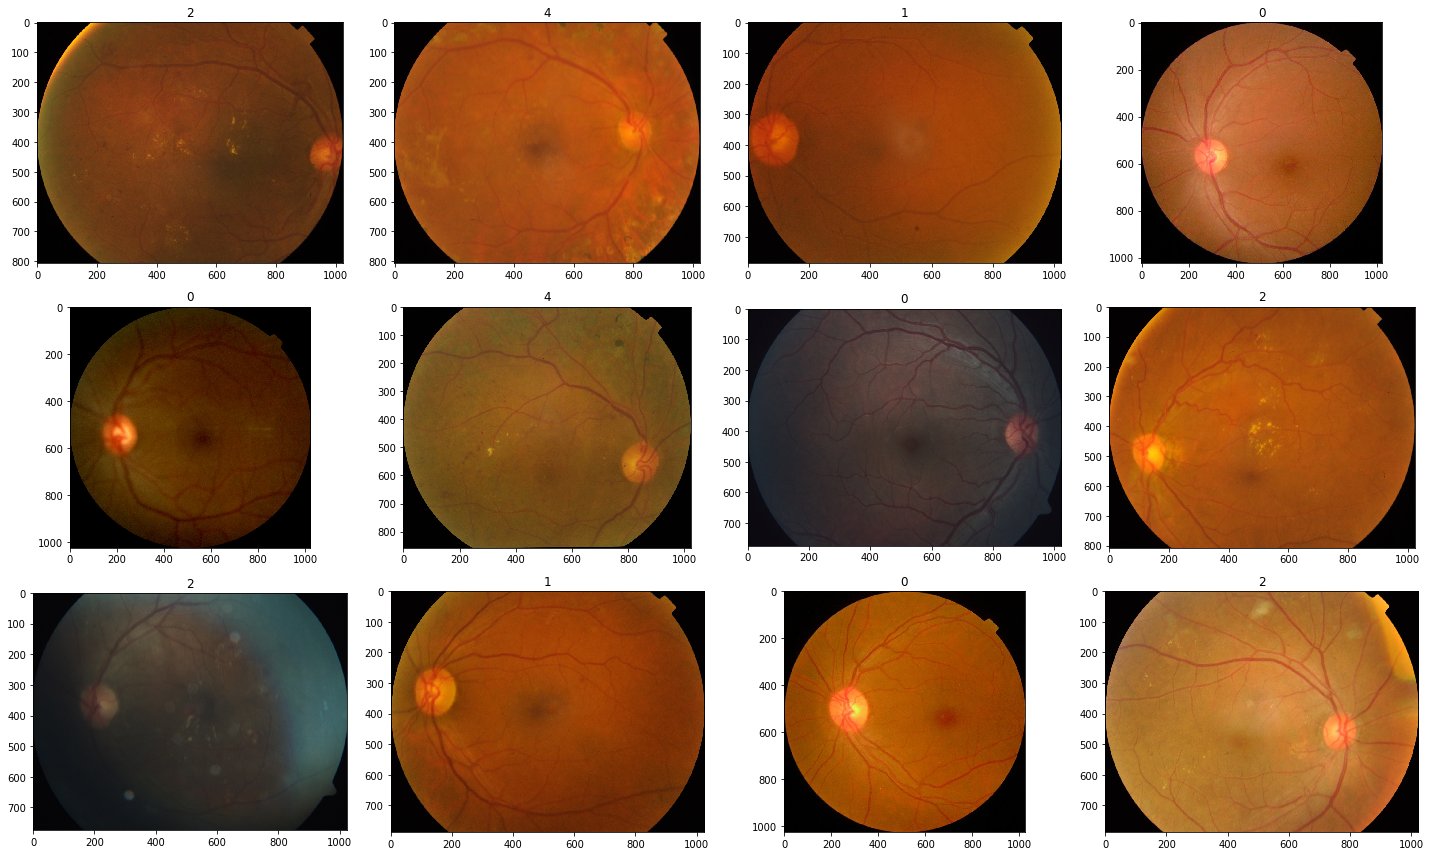

In [10]:
display_samples(train_df)

We will modify the code present in the url mentionded below to suit our needs. As we know that the Images are not all the same size, we will not use this to crop the images below to be used in our CNN. https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized

In [11]:
#a = processing(image_path_array,5,244,244)

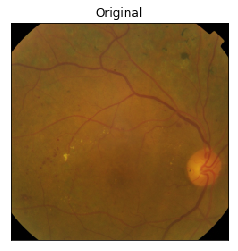

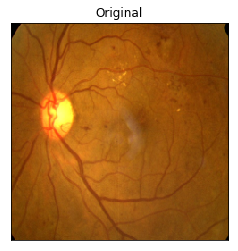

In [11]:
train_images = processing(image_path_array, 50,100,100) 
test_images =  processing(test_data_image_path_array, 10,100,100) 

In [12]:
# b = image_path_array[:len(train_images)]
# id_code = b[0][18:-4]
# print(id_code)
train_classes = train_df['diagnosis'][:50]
test_classes = test_df['level'][:10]

print(len(train_classes))

50


In [13]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [14]:
train_images = np.asarray(train_images) /255.0
train_classes = np.asarray(train_classes)

test_images = np.asarray(test_images) /255.0
test_classes = np.asarray(test_classes) 

In [15]:
print()

In [16]:

def Inception(input_image):
    First_layer = keras.Input(shape=input_image.shape) # Input Value
    
    
    # = keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same')(image_input) # First Convolution to get things rolling
    
    
    #Inception Block 1.
    
    #String1
    
    block1_string1 = keras.layers.Conv2D(1, (1, 1), activation='relu', padding = 'same')(First_layer) #1x1 Convolution
    block1_string1 = keras.layers.Conv2D(1, (1, 1), activation='relu', padding = 'same')(block1_string1) #Followed By 3x3 Convolution
    
    # String2
    block1_string2 = keras.layers.Conv2D(1, (1, 1), activation='relu', padding = 'same')(First_layer) #1x1 Convolution
    block1_string2 = keras.layers.Conv2D(1, (5,5), activation='relu', padding = 'same')(block1_string2) #Followed By 5x5 Convolution
    
    #String3
#     block1_string3 = keras.layers.MaxPooling2D((3, 3),strides = (1,1))(First_layer) #3x3 MaxPooling Layer.
#     block1_string3 = keras.layers.Conv2D(64, (1,1), activation='relu', padding = 'same')(block1_string3) #Followed By 1x1 Convolution
    
    #String4
    block1_string4 = keras.layers.Conv2D(1, (1,1), activation='relu', padding = 'same')(First_layer) #1x1 Convolution
    
    
    block1_output = keras.layers.concatenate([block1_string1,block1_string2,block1_string4], axis=3)
    
    flatten = keras.layers.Flatten()(block1_output)
    dense_to_output = keras.layers.Dense(1, activation='relu')(flatten)
    output_classes = keras.layers.Dense(num_classes, activation='softmax')(dense_to_output)
    
    model = keras.Model(inputs=First_layer, outputs=output_classes)
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [17]:
model = Inception(train_images[0])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 244, 244, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 244, 244, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 244, 244, 1)  2           conv2d[0][0]                     
______________________________________________________________________________________________

In [21]:
history = model.fit(train_images, to_categorical(train_classes), epochs=10 , batch_size=32)

Train on 50 samples
Epoch 1/10
50/50 [==============================] - 7s 138ms/sample - loss: 1.5887 - accuracy: 0.3600
Epoch 2/10
50/50 [==============================] - 2s 37ms/sample - loss: 1.4453 - accuracy: 0.3000
Epoch 3/10
50/50 [==============================] - 2s 36ms/sample - loss: 1.4015 - accuracy: 0.3000
Epoch 4/10
50/50 [==============================] - 2s 36ms/sample - loss: 1.2992 - accuracy: 0.3000
Epoch 5/10
50/50 [==============================] - 2s 36ms/sample - loss: 1.2375 - accuracy: 0.3000
Epoch 6/10
50/50 [==============================] - 2s 40ms/sample - loss: 1.2048 - accuracy: 0.3000
Epoch 7/10
50/50 [==============================] - 2s 33ms/sample - loss: 1.1511 - accuracy: 0.3000
Epoch 8/10
50/50 [==============================] - 2s 35ms/sample - loss: 1.1163 - accuracy: 0.3000
Epoch 9/10
50/50 [==============================] - 2s 38ms/sample - loss: 1.1224 - accuracy: 0.3000
Epoch 10/10
50/50 [==============================] - 2s 38ms/sample - 

10/1 - 0s - loss: 14.5788 - accuracy: 0.4000


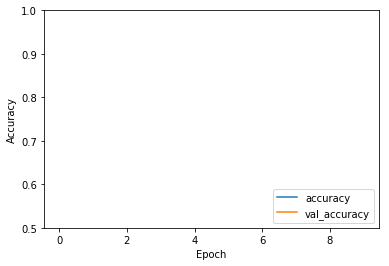

In [56]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

train_loss, train_acc = model.evaluate(test_images,  test_classes, verbose=2)

In [57]:
print("current models Accuracy On it's self {} ".format(train_acc))

current models Accuracy On it's self 0.4000000059604645 


In [ ]:
tf.version()